## Sistema de Detección de Cancer de Piel

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
!pip install plotly
import plotly.graph_objects as go
import cv2
import pandas as pd
import os
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, f1_score

path = '/content/drive/MyDrive/Python-R-SQL/Python/Deep_Learning_Computer_Vision/2-Clasificador_Lunares/'
os.listdir(path)

def graphics_rgb(imagen, titulo):
  fig, ax = plt.subplots(1, 1, figsize = (12, 5))
  ax.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
  plt.title(titulo)
  plt.grid(False)
  plt.show()

def graphics_one_canal(imagen, titulo):
  fig, ax = plt.subplots(1, 1, figsize = (12, 5))
  ax.imshow(imagen)
  plt.title(titulo)
  plt.grid(False)
  plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<hr>

Este proyecto se trata de formar un sistema básico de detección de cancer, se incursionará en algunos métodos tanto de procesamiento de imágenes, una debida segmentación, para luego extraer las características y la clasificación.

<hr>

In [3]:
path_images = path + 'datasetLunares/'
dysplasticNevi = path_images + 'dysplasticNevi/train/'
spitzNevus = path_images + 'spitzNevus/train/'

imgs_DN = os.listdir(dysplasticNevi)
imgs_SN = os.listdir(spitzNevus)

print(imgs_DN)
print(imgs_SN)

['dysplasticNevi6.jpg', 'dysplasticNevi7.jpg', 'dysplasticNevi9.jpg', 'dysplasticNevi8.jpg', 'dysplasticNevi5.jpg', 'dysplasticNevi1.jpg', 'dysplasticNevi10.jpg', 'dysplasticNevi4.jpg', 'dysplasticNevi2.jpg', 'dysplasticNevi3.jpg']
['spitzNevus10.jpg', 'spitzNevus2.jpg', 'spitzNevus3.jpg', 'spitzNevus6.jpg', 'spitzNevus9.jpg', 'spitzNevus1.jpg', 'spitzNevus8.jpg', 'spitzNevus7.jpg', 'spitzNevus5.jpg', 'spitzNevus4.jpg']


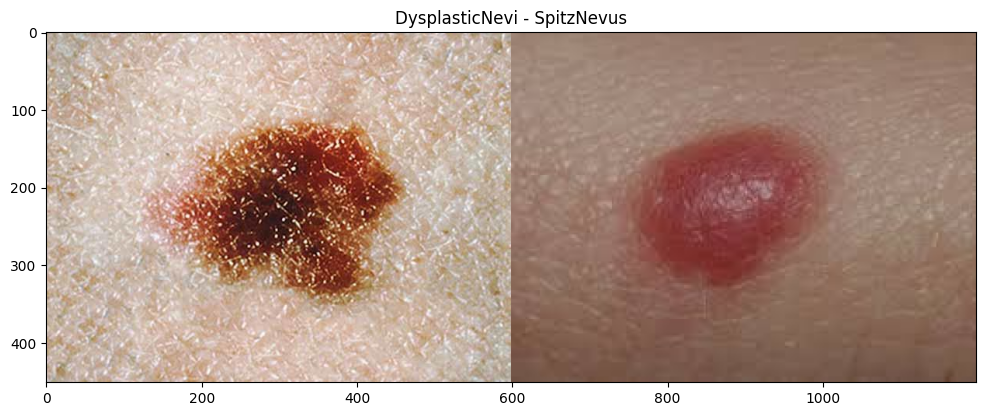

In [4]:
#Veamos una imagen para cada lista (Uniremos las imagenes)
img1 = cv2.imread(dysplasticNevi + imgs_DN[0])
img2 = cv2.imread(spitzNevus + imgs_SN[0])

#Interpolaremos pues las imagenes tienen una diferencia de dimensiones muy grande
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]), interpolation = cv2.INTER_AREA)

#Unimos imagenes y graficamos
img = np.hstack((img1, img2))
graphics_rgb(img, 'DysplasticNevi - SpitzNevus')

In [5]:
#Crearemos una función para extraer las caracteristicas de nuestras imagenes
def get_features(img):

  #Pasamos a escala de grises
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  #Obtenemos umbral para la binarizacion con metodo otsu
  _, img_bin = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  #Obtenemos la zona de interes en cada canal
  B, G, R = img[: , : , 0] * img_bin, img[: , : , 1] * img_bin, img[: , : , 2] * img_bin

  #Ahora en la zona de interes generaremos un valor respresentativo para cada canal
  sum_bin = np.sum(img_bin)
  B, G, R = np.sum(B) / sum_bin, np.sum(G) / sum_bin, np.sum(R) / sum_bin

  #Normalizamos
  B, G, R = B / 255, G / 255, R / 255

  return [B, G, R]

#Observacion: Esta funcion de extraccion de caracteristicas, se basa solo
#en la hipotesis de que nos importa solo el color

In [58]:
#Formacion de dataframes
def getDataFrame(path, path_images_list, label):

  #Lista de caracteristicas
  features = []

  #Recorresmos los nombres de las imagenes
  for img in path_images_list:

    #Abrimos las imagenes en modelo BGR
    img = cv2.imread(path + img)

    #Extraemos caracteristicas y label
    features.append(get_features(img) + [label])

  #Formamos dataframe
  data = pd.DataFrame(features, columns = ['blue', 'green', 'red', 'label'])

  return data

In [7]:
data_DN = getDataFrame(dysplasticNevi, imgs_DN, 'DysplasticNevi')
print(data_DN.shape)
data_DN.head()

(10, 4)


,blue,green,red,label
0,0.143836,0.230007,0.484646,DysplasticNevi
1,0.225838,0.225289,0.299527,DysplasticNevi
2,0.173647,0.210161,0.422095,DysplasticNevi
3,0.147409,0.227934,0.471910,DysplasticNevi
4,0.176517,0.286826,0.580837,DysplasticNevi


In [8]:
data_SN = getDataFrame(spitzNevus, imgs_SN, 'SpitzNevus')
print(data_SN.shape)
data_SN.head()

(10, 4)


,blue,green,red,label
0,0.295583,0.339659,0.515299,SpitzNevus
1,0.175706,0.137231,0.479516,SpitzNevus
2,0.294938,0.338899,0.514235,SpitzNevus
3,0.350362,0.446898,0.517467,SpitzNevus
4,0.239095,0.307462,0.699106,SpitzNevus


In [9]:
#Unimos los datasets
data = pd.concat([data_DN, data_SN], ignore_index = True)

#Reemplazamos los valores categoricos
data['label'] = data['label'].replace({'DysplasticNevi' : -1, 'SpitzNevus' : 1})

print(data.shape)
data.head(-1)

(20, 4)


,blue,green,red,label
0,0.143836,0.230007,0.484646,-1
1,0.225838,0.225289,0.299527,-1
2,0.173647,0.210161,0.422095,-1
3,0.147409,0.227934,0.471910,-1
4,0.176517,0.286826,0.580837,-1
5,0.286873,0.355402,0.568037,-1
6,0.219808,0.274427,0.476708,-1
7,0.184237,0.296356,0.594271,-1
8,0.265665,0.293202,0.527082,-1
9,0.180826,0.320295,0.491696,-1


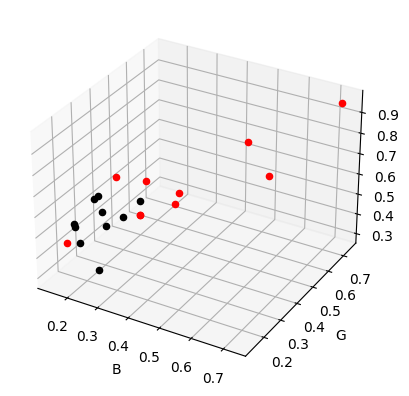

In [10]:
#Visualicemos los datos en el espacio de caracteristicas
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

for i in range(0, data.shape[0]):

  if data.loc[i]['label'] == -1:
    ax.scatter(data.loc[i]['blue'], data.loc[i]['green'], data.loc[i]['red'], c = 'k')
  
  else:
    ax.scatter(data.loc[i]['blue'], data.loc[i]['green'], data.loc[i]['red'], c = 'r')

ax.set_xlabel('B')
ax.set_ylabel('G')
ax.set_zlabel('R')
plt.show()

<hr>

Podemos ver que hay cierta separación entre las distintas clases, pero existen datos que nos darían una clase erronea si ocupamos directamente un hiperplano. Es por esto que se puede decir que el problema no es linealmente separable.

<hr>

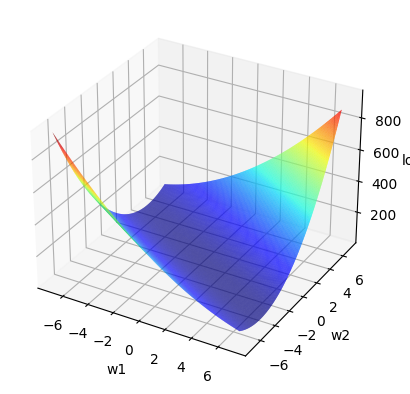

In [11]:
#Ahora veremos como se comporta una regresion lineal para clasificar estas imágenes
#Se utilizara el metodo de minimos cuadrados

#Pasamos los valores numericos a listas
data = data.to_numpy()
subFeatures = data[: , 1 : 3]
labels = data[:, -1]

#Lista que se llenara con el valor de la loss y los parametros w1, w2
Ws, loss = [], []

#Le ofrecemos un rango pequeño a w1 y w2 para ver los valores que puede tomar y asi minimizar la funcion de erro
for w1 in np.linspace(-7.0, 7.0, 200):
  for w2 in np.linspace(-7.0, 7.0, 200):
    error = 0
    for i, featureRow in enumerate(subFeatures):
      minSquare = (w1 * featureRow[0] + w2 * featureRow[1] - labels[i]) ** 2
      error = error + minSquare
    
    Ws.append([w1, w2])
    loss.append(error)

Ws = np.array(Ws)

#Grafiquemos los parametros en funcion de la loss
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_trisurf(Ws[:, 0], Ws[:, 1], loss, cmap = cm.jet, linewidth = 0)
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('loss')
plt.show()

<hr>

Debemos notar que en lo anterior no utilizamos toda la información, solo nos centramos en los canales *Green* y *Red*. Ahora utilizaremos toda la información, y conociendo que por medio de la estimación, sabemos que el hiperplano óptimo que mínimiza el error está dado por

$$w = A^{-1} \cdot b$$

donde $A = \sum_{i = 1}^n x_i \cdot x_i^T$, y $b = \sum_{i = 1}^n x_i \cdot y_i$

In [12]:
#Aca tenemos la matriz con w0, w1, w2 y el intercepto
A = np.zeros((4, 4))
b = np.zeros((4, 1))

#Caracteristicas
features = data[:, : 3]

#Recorremos las caracteristicas
for i, featureRow in enumerate(features):

  #Vector de caracteristicas (se le debe agregar el 1 por el intercepto)
  x = np.append([1], featureRow)
  x = x.reshape((4, 1))
  y = labels[i]

  #Sumatoria para formar A
  A = A + x * x.T

  #Sumatoria para formar b
  b = b + x * y

invA = np.linalg.inv(A)

W = np.dot(invA, b)

print(f'{invA}\n')
print(f'{b}\n')
print(f'\nLos pesos W = {W.T[0]}\n')


[[  1.07522065   1.63136432  -0.80073711  -2.16063209]
 [  1.63136432  23.51901998 -25.81343851   0.60565799]
 [ -0.80073711 -25.81343851  37.28165437  -7.83114077]
 [ -2.16063209   0.60565799  -7.83114077   8.23131249]]

[[0.        ]
 [1.8869352 ]
 [1.46342583]
 [1.54994114]]


Los pesos W = [-1.44239315  7.54154832 -6.28715713  2.44059355]



In [20]:
#Como ya tenemos los pesos y el intercepto del hiperplano que separara nuestras clases
#Lo graficamos, sabiendo que la ecuacion de la recta es la siguiente
#w1*X + w2*Y + w3*Z + w0 = 0

#Rangos
X, Y = np.arange(0, 1, 0.1), np.arange(0, 1, 0.1)
X, Y = np.meshgrid(X, Y)

Z = -(W[1]*X + W[2]*Y + W[0]) / W[3]

#Graficamos superficie (Hiperplano)
fig = go.Figure(data = [go.Surface(x = X, y = Y, z = Z)])

#Graficamos los datos de manera Scatter, separando las clases
for i in range(0, data.shape[0]):
  if data[i, 3] == -1:
    fig.add_trace(go.Scatter3d(x = np.array(data[i, 0]), y = np.array(data[i, 1]), z = np.array(data[i, 2]),
                               mode = 'markers', marker = dict(size = 5, color = 'blue')))
  else:
    fig.add_trace(go.Scatter3d(x = np.array(data[i, 0]), y = np.array(data[i, 1]), z = np.array(data[i, 2]),
                               mode = 'markers', marker = dict(size = 5, color = 'red')))

fig.update_layout(scene=dict(xaxis=dict(title='Eje X'), yaxis=dict(title='Eje Y'), zaxis=dict(title='Eje Z')))

#Muestra el gráfico interactivo
fig.show()

#### Calculando el Error

La Precision del modelo es: 0.875
El Accuracy del modelo es: 0.8
El F-Score del modelo es: 0.7777777777777777


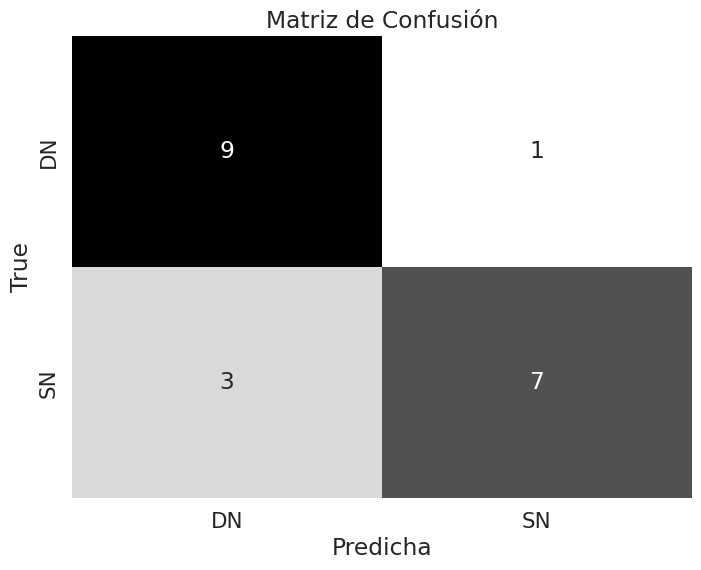

In [52]:
#Predicciones de las etiquetas
prediccion = np.sign((W[0] + np.dot(features, W[1::]))).reshape((20,))

precision = precision_score(data[:, 3], prediccion)
accuracy = accuracy_score(data[:, 3], prediccion)
fscore = f1_score(data[:, 3], prediccion)
confusion = confusion_matrix(data[:, 3], prediccion)

print(f'La Precision del modelo es: {precision}')
print(f'El Accuracy del modelo es: {accuracy}')
print(f'El F-Score del modelo es: {fscore}')

plt.figure(figsize=(8, 6))
sns.set(font_scale = 1.4)  # Tamaño de fuente
sns.heatmap(confusion, annot = True, fmt = 'd', cmap = 'Greys', cbar = False)

# Añadir etiquetas a los ejes
tick_marks = np.arange(len(confusion))
plt.xticks(tick_marks + 0.5, ['DN', 'SN'], ha='center')
plt.yticks(tick_marks + 0.5, ['DN', 'SN'], va='center')

# Añadir título y etiquetas de los ejes
plt.xlabel('Predicha')
plt.ylabel('True')
plt.title('Matriz de Confusión')

# Mostrar el gráfico
plt.show()

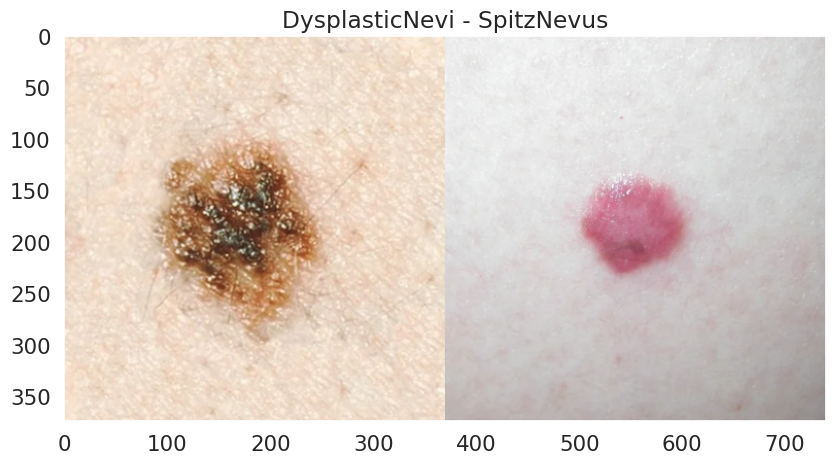

In [56]:
#Ejemplo de como seria  el proceso de prediccion para imagenes nuevas
sn_img = cv2.imread(path_images + 'spitzNevus/spitz.png')
dn_img = cv2.imread(path_images + 'dysplasticNevi/dysplastic.png')

#Unimos imagenes y graficamos
img = np.hstack((dn_img, sn_img))
graphics_rgb(img, 'DysplasticNevi - SpitzNevus')

In [65]:
clases = {1 : 'SpitzNevus', -1 : 'DysplasticNevi'}

#Obtenemos los atributos con la funcion definida anteriormente
feature_sn = np.array(get_features(sn_img))
feature_dn = np.array(get_features(dn_img))

#Predecimos
result_sn = np.sign(W[0] + np.dot(feature_sn, W[1 : :])).reshape((1,))[0]
result_dn = np.sign(W[0] + np.dot(feature_dn, W[1 : :])).reshape((1,))[0]

print(f'La imagen con lunar SpitzNevus se predijo como: {clases[result_sn]}')
print(f'La imagen con lunar DysplasticNevi se predijo como: {clases[result_dn]}')

La imagen con lunar SpitzNevus se predijo como: SpitzNevus
La imagen con lunar DysplasticNevi se predijo como: DysplasticNevi
